In [ ]:
##NOT FINISHED

In [1]:
import math
import json
import string
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [16]:
def divergence_simulated_data(scheme, rep, gene, window, min_seqs, year_max=None, year_min=None):
    #Find fraction of sites that differ from root and average among all viruses at each time point
    input_file_alignment = '../santa-sim_oc43a/santa-sim_oc43a-'+str(gene)+'/results/aligned_'+str(scheme)+'_'+str(rep)+'.fasta'
    
    if gene == 's1' or gene == 's2':
        metafile = '../santa-sim_oc43a/santa-sim_oc43a-spike/results/metadata_'+str(scheme)+'_'+str(rep)+'.tsv'
    else:
        metafile = '../santa-sim_oc43a/santa-sim_oc43a-'+str(gene)+'/results/metadata_'+str(scheme)+'_'+str(rep)+'.tsv'
    

    
    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    
    

    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 1
            date_window_start += 1     

    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []
    total_subs_fractions = []
    syn_fractions = []
    nonsyn_fractions = []
    total_subs_fractions_avg = []
    syn_fractions_avg = []
    nonsyn_fractions_avg = []
    
    #track all mutations that occur in tree
    nt_muts = []
    
    #strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    root_seq = ''
    root_aa_seq = ''
    
    for years, subset_viruses in virus_time_subset.items():
        #don't use windows with fewer than min_seqs 
        if len(subset_viruses) >= min_seqs:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))
    
            
            #make consensus sequence at first time point
            if first_window == True:
                first_window_strains+=subset_viruses
                with open(input_file_alignment, "r") as aligned_handle:
                    for virus in SeqIO.parse(aligned_handle, "fasta"):
                        if virus.id in first_window_strains:
                            first_window_sequences.append(virus)
                            
                first_window_alignment = MultipleSeqAlignment(first_window_sequences)
                root_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
                root_aa_seq = root_seq.translate()
                
                first_window = False
            
        
        
            
            fraction_subs = []
            fraction_syn = []
            fraction_nonsyn = []
            
            #calculate divergence at all subsequent time points
            with open(input_file_alignment, "r") as aligned_handle:
                for virus in SeqIO.parse(aligned_handle, "fasta"):         
#                     Only viruses in time window
                    if virus.id in subset_viruses:    
                        
                        #check
                        if len(virus.seq) != len(root_seq):
                            print(virus)
                        elif len(virus.seq) == len(root_seq):
                            count_total_unambiguous = 0
                            count_subs = 0
                            count_syn_subs = 0
                            count_nonsyn_subs = 0
                            for pos in range(len(root_seq)):
                                root_nt = str(root_seq[pos])
                                virus_nt = str(virus.seq[pos])
                                #skip ambiguous sites
                                if virus_nt != 'N':
                                    if root_nt != 'N':
                                        count_total_unambiguous+=1
                                        if virus_nt != root_nt:
                                            count_subs+=1
                                            #determine syn or nonsyn
                                            codon = math.floor(pos/3)
                                            codon_pos = pos-(codon*3)
                                            if codon_pos == 0:
                                                codon_nt = virus.seq[pos:(pos+3)]
                                            elif codon_pos == 1:
                                                codon_nt = virus.seq[(pos-1):(pos+2)]
                                            elif codon_pos == 2:
                                                codon_nt = virus.seq[(pos-2):(pos+1)]
                                            codon_aa = codon_nt.translate()
                                            root_aa = root_aa_seq[codon]
                                            #skip ambiguous
                                            if root_aa != 'X':
                                                if codon_aa != root_aa:
                                                    count_nonsyn_subs+=1
                                                    nt_mut = str(root_nt)+str(pos)+str(virus_nt)+'nonsyn'
                                                elif codon_aa == root_aa:
                                                    count_syn_subs+=1
                                                    nt_mut = str(root_nt)+str(pos)+str(virus_nt)+'syn'
                                                if nt_mut not in nt_muts:
                                                    nt_muts.append(nt_mut)
                            fraction_sub_virus = count_subs/count_total_unambiguous
                            fraction_subs.append(fraction_sub_virus)
                            fraction_syn_virus = count_syn_subs/count_total_unambiguous
                            fraction_syn.append(fraction_syn_virus)
                            fraction_nonsyn_virus = count_nonsyn_subs/count_total_unambiguous
                            fraction_nonsyn.append(fraction_nonsyn_virus)



            fraction_subs_window = sum(fraction_subs)/len(fraction_subs)
            fraction_syn_window = sum(fraction_syn)/len(fraction_syn)
            fraction_nonsyn_window = sum(fraction_nonsyn)/len(fraction_nonsyn)
            
            total_subs_fractions.append(fraction_subs)
            syn_fractions.append(fraction_syn)
            nonsyn_fractions.append(fraction_nonsyn)
            
            total_subs_fractions_avg.append(fraction_subs_window)
            syn_fractions_avg.append(fraction_syn_window)
            nonsyn_fractions_avg.append(fraction_nonsyn_window)
            
    return year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg, nt_muts


In [40]:
def plot_simulated_divergence(schemes, reps, genes, window, min_seqs, year_max=None, year_min=None, filename=None):

    rdrp_scheme_map = {'1':'1', '2':'1', '3':'1', '4':'1', 
               '5':'5', '6':'5', '7':'5', '8':'5', 
               '9':'9', '10':'9', '11':'9', '12':'9', 
               '13':'13', '14':'13', '15':'13', '16':'13'}

    data_to_plot = []
    

    for scheme in schemes:
        for rep in reps:
            for gene in genes:
                if gene == 'rdrp':
                    simulation_scheme = scheme[0]+str(rdrp_scheme_map[scheme[1:]])
                else:
                    simulation_scheme = scheme
                

                year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg, nt_muts = divergence_simulated_data(simulation_scheme, rep, gene, window, min_seqs, year_max, year_min)

                for window_index in range(len(year_windows)):

                    for virus_syn in syn_fractions[window_index]:
                        data_to_plot.append({'year': year_windows[window_index][0:4], 
                                             'scheme': scheme, 'gene': gene, 'rep': rep, 
                                             'substitution': 'syn', 
                                             'divergence': virus_syn, 'cov': 'oc43a_simulated'})
                    for virus_nonsyn in nonsyn_fractions[window_index]:
                        data_to_plot.append({'year': year_windows[window_index][0:4], 
                                             'scheme': scheme, 'gene': gene, 'rep': rep, 
                                             'substitution': 'nonsyn', 
                                             'divergence': virus_nonsyn, 'cov': 'oc43a_simulated'})

    df_to_plot = pd.DataFrame(data_to_plot)
    df_to_plot['year'] = df_to_plot['year'].astype('int')
    
    recombination_key = myDict = {
        **dict.fromkeys(['1', '2', '3', '4'], 'No Recombination'), 
        **dict.fromkeys(['5', '6', '7', '8'], 'Low Recombination'),
        **dict.fromkeys(['9', '10', '11', '12'], 'Moderate Recombination'),
        **dict.fromkeys(['13', '14', '15', '16'], 'High Recombination')}
    
    selection_key = myDict = {
        **dict.fromkeys(['1', '5', '9', '13'], 'No Positive Selection'), 
        **dict.fromkeys(['2', '6', '10', '14'], 'Low Positive Selection'),
        **dict.fromkeys(['3', '7', '11', '15'], 'Moderate Positive Selection'),
        **dict.fromkeys(['4', '8', '12', '16'], 'High Positive Selection')}
    
    #add columns to plot facet grid on
    df_to_plot['scheme_num'] = df_to_plot['scheme'].str[1:]
    df_to_plot['recombination'] = df_to_plot['scheme_num'].map(recombination_key)
    df_to_plot['selection'] = df_to_plot['scheme_num'].map(selection_key)
    
    color_map = {'rdrp':'#FF9A00', 'spike': '#009888', 's1': '#87C735', 's2': '#2E86C1'}

    
#     sns.set(font_scale=2)
#     sns.set_style("white")
# #     sns.set_context(rc={"legend.fontsize":24})
#     plt.rcParams["legend.markerscale"] = 3.0
#     plt.rcParams['lines.linewidth'] = 6


    
    g = sns.relplot(x='year', y='divergence', hue='gene', style = 'substitution', palette = color_map,
                    kind = 'line', legend = 'full', row='selection', col='recombination', 
                    facet_kws=dict(sharex=False, sharey=False), 
                    height=5, aspect=1.5, ci=95, data = df_to_plot)
#                     err_style="bars", err_kws={'elinewidth':2},
#                     markers = True, markersize = 12, 

    #.set_titles("{col_name}", fontweight='bold')
    
    
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        ax.tick_params(axis='both', which='major', labelsize=16)
        
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='xx-large')
        if ax.get_ylabel():
            ax.set_ylabel('Adaptive Subs per Codon per Year (x10^-3)', fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='xx-large')

        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='xx-large')
            # Remove the original text
            ax.texts[0].remove()
#     for ax in g.axes.flat:
#         ax.set_xlabel('')
    
    if filename:
        g.savefig(filename, dpi=300)


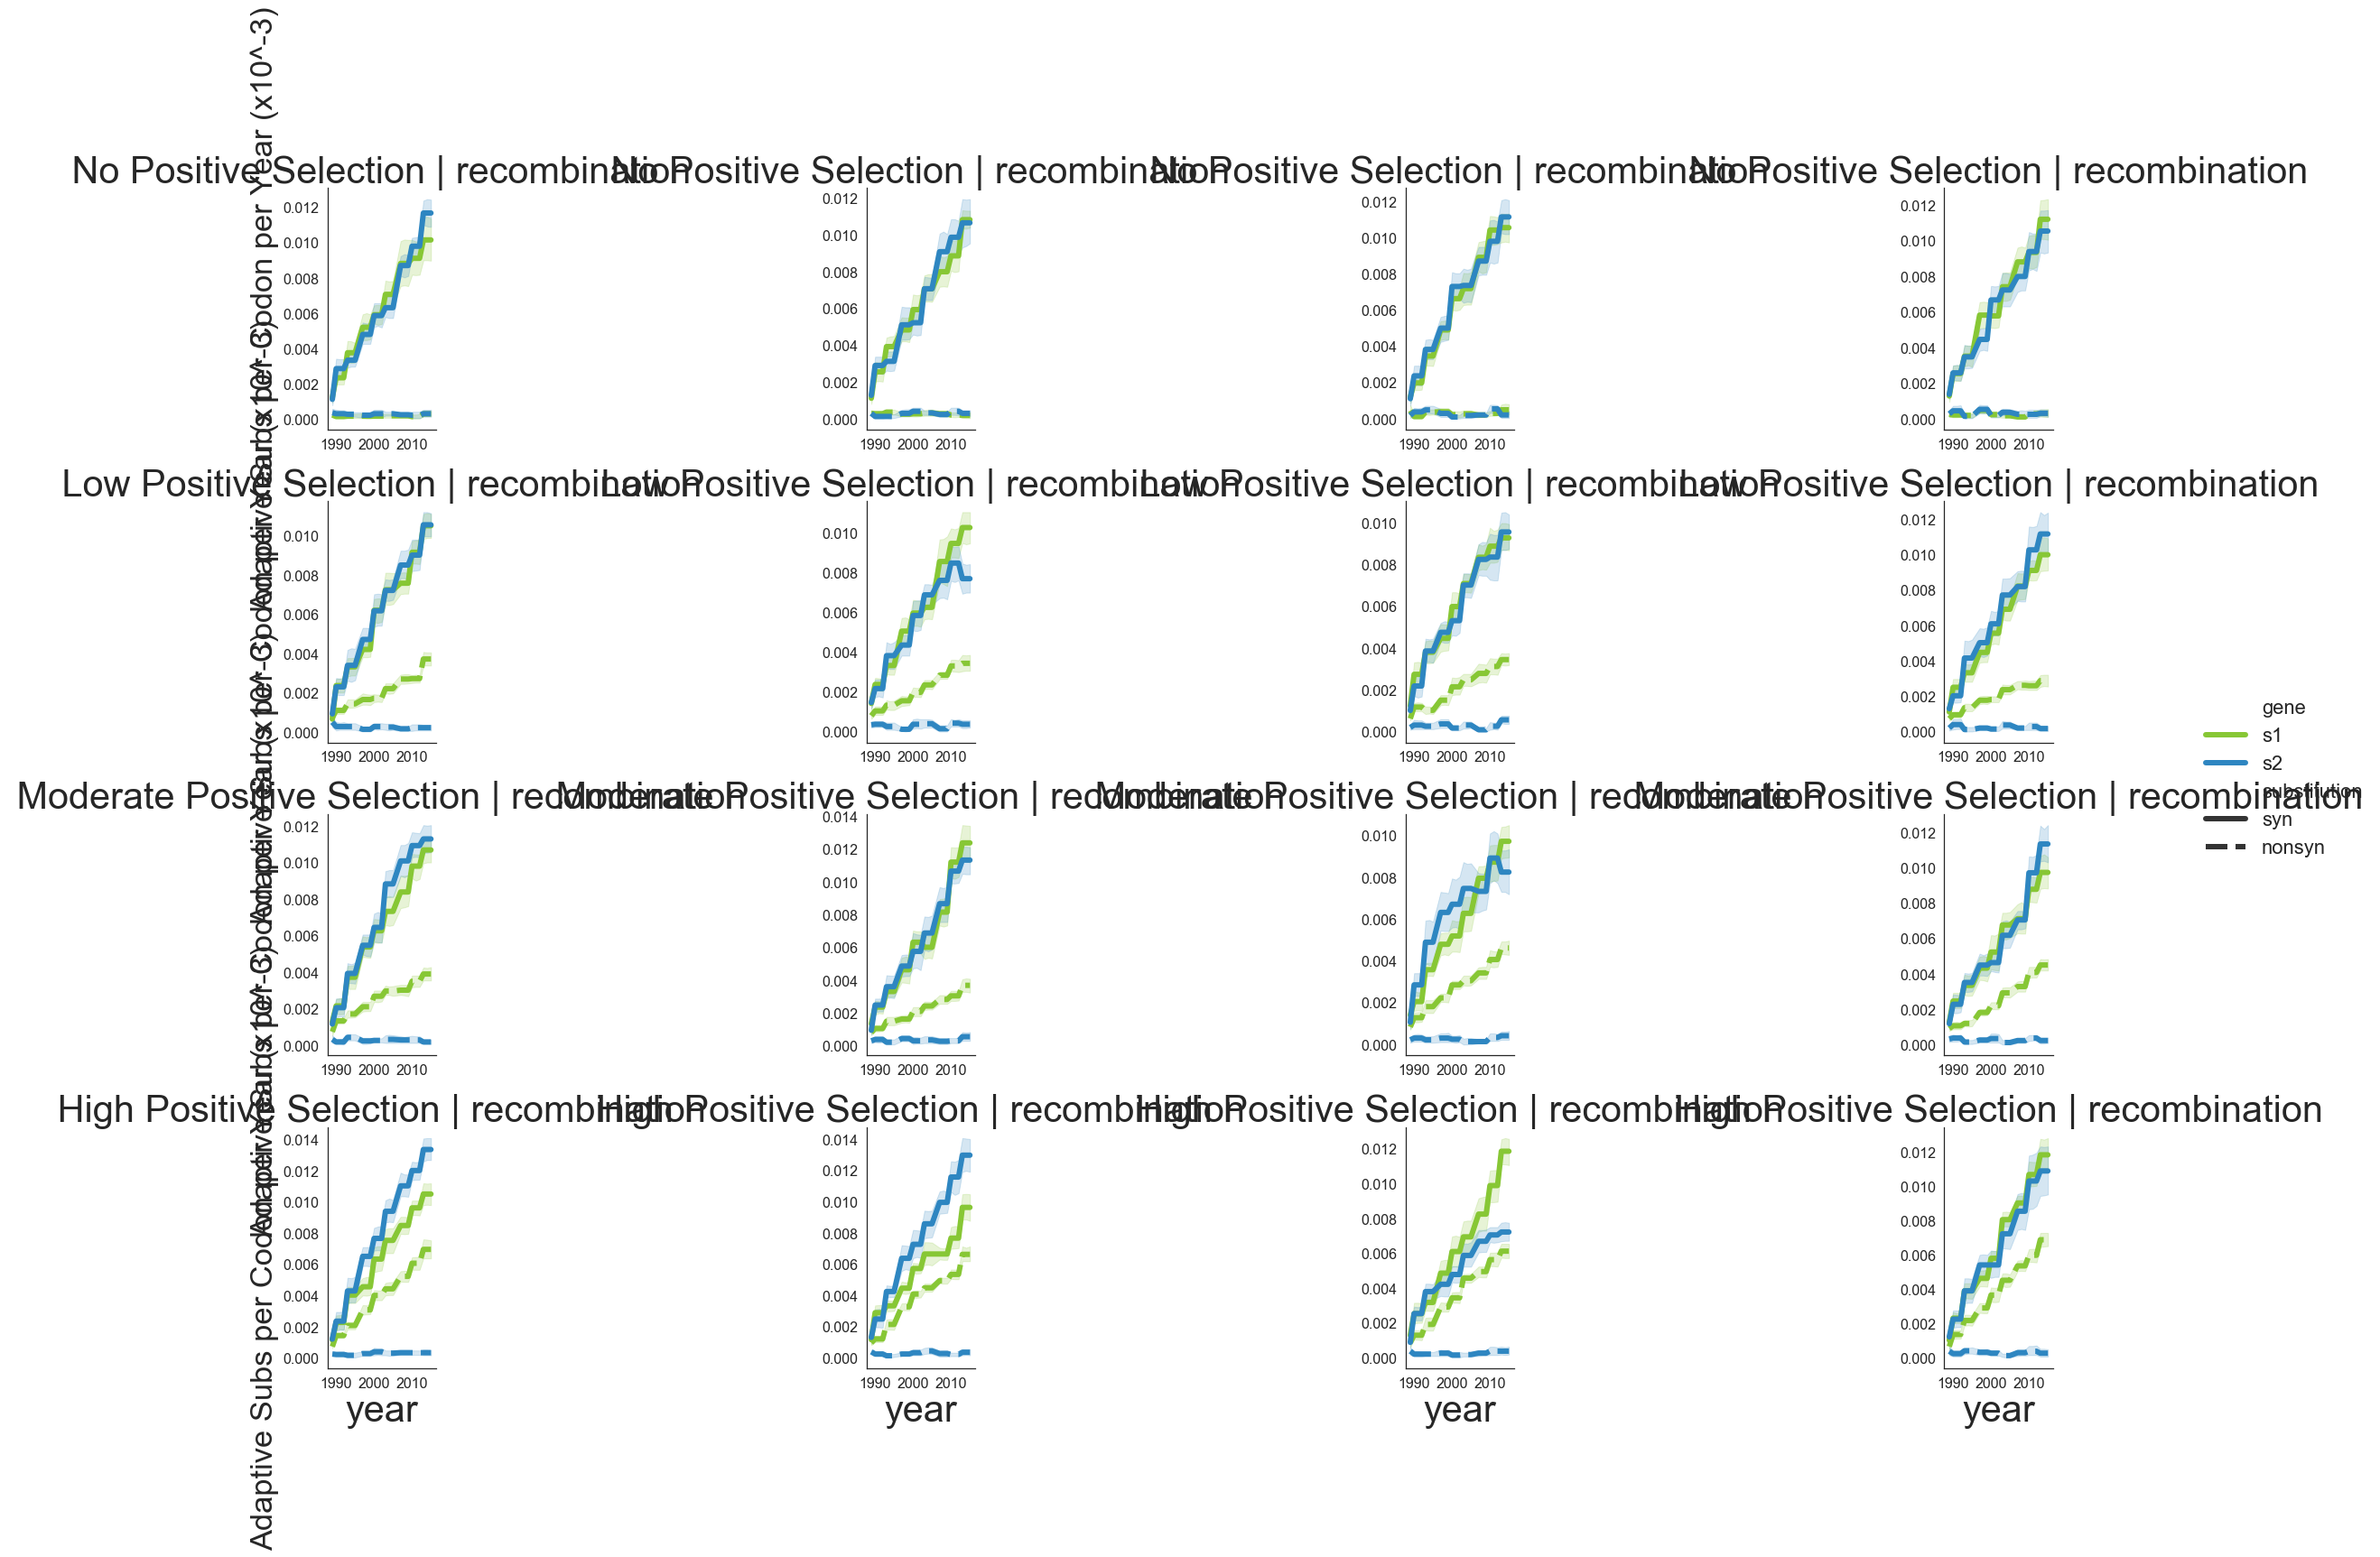

In [41]:
plot_simulated_divergence(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 
                           's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16'], 
                          ['1', '2'], ['s1', 's2'], 3, 2)